### Wire cutting as a method to improve performance of quantum circuits

Circuit-knitting is an umbrella term which encapsulates various methods of partitioning a circuit in multiple smaller subcircuits involving fewer gates and/or qubits. Each of the subcircuits can be executed independently and the final result is obtained via some classical postprocessing over the outcome of each subcircuit.

This notebook deals with a method called <b>wire cutting</b> where the circuit is partitioned along the wire [1,2]. Note that, partitioning is simple in classical circuits since the outcome at the point of partition can be determined deterministically, and is either 0 or 1. However, the state of the qubit at the point of the cut is, in general, a mixed state. Therefore, each subcircuit needs to be measured multiple times in different basis (usually a tomographically complete set of basis such as the Pauli basis [3,4]) and correspondingly prepared in its eigenstate. The Figure below (<i>courtesy: PhD Thesis, Ritajit Majumdar</i>) shows an example of wire cutting for a 4-qubit GHZ state into three subcircuits. Here $M_j$ denote a set of basis (usually Pauli X, Y and Z) and $P_i$ denote a set of eigenstates (usually $|0\rangle$, $|1\rangle$, $|+\rangle$ and $|+i\rangle$).

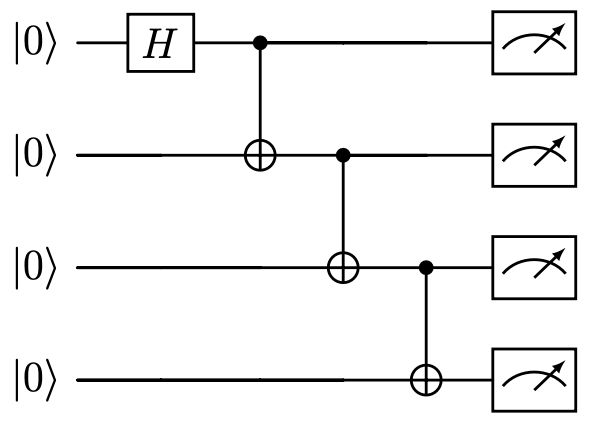
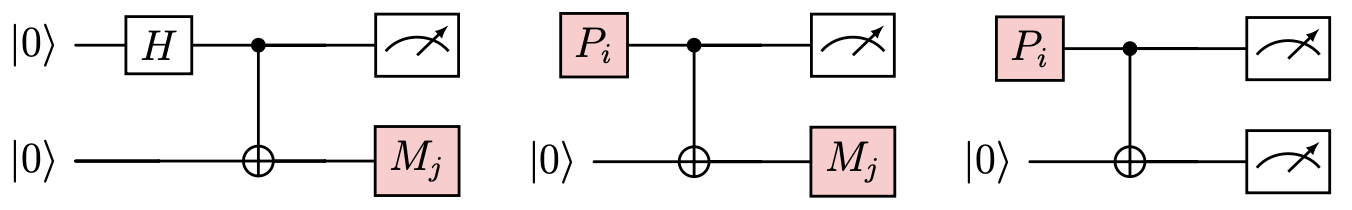

Since each subcircuit has fewer qubits and/or gates, they are expected to be less amenable to noise. This notebook shows an example where this method can be used to effectively suppress the noise in the system.

### Start

We shall take a QAOA circuit as an example for this notebook.

### Build

Here we show the function to build a QAOA circuit. Initially we build a template circuit without any specific parameter values. We also provide placeholders, called **CutWire**, to annotate the position of cuts.

In [1]:
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter, ParameterVector
from numpy.random import default_rng
from numpy import pi
from typing import Optional

from circuit_knitting.cutting.instructions import CutWire

def build_qaoa_circuit(
    num_qubits: int,
    depth: int, # here the convention is depth=2*p,
    use_cut: bool = False,
    cut_qubit: Optional[int] = None,
    ):
    gammas = ParameterVector('γ', depth // 2) 
    betas = ParameterVector('β', depth // 2)

    if use_cut and cut_qubit is None:
        cut_qubit = num_qubits//2
        if cut_qubit%2 == 0:
            cut_qubit += 1

    if use_cut:
        assert cut_qubit%2 == 1, "cut_qubit should be odd"

    circuit = QuantumCircuit(num_qubits)
    circuit.h(range(num_qubits))
    for layer in range(depth // 2):
        for qubit in range(0, num_qubits - 1, 2):
            if use_cut and qubit == cut_qubit+1:
                if layer == 0:
                    circuit.rzz(gammas[layer], qubit, qubit + 1)
                    circuit.append(CutWire(),[qubit])
                else:
                    circuit.append(CutWire(),[qubit])
                    circuit.rzz(gammas[layer], qubit, qubit + 1)
                    circuit.append(CutWire(),[qubit])
            else:
                circuit.rzz(gammas[layer], qubit, qubit + 1)
        for qubit in range(1, num_qubits - 1, 2):
            if use_cut and qubit == cut_qubit+1:
                circuit.append(CutWire(),[qubit])
                circuit.rzz(gammas[layer], qubit, qubit + 1)
                #circuit.append(CutWire(),[qubit])
            else:
                circuit.rzz(gammas[layer], qubit, qubit + 1)
        for qubit in range(num_qubits):
            circuit.rx(betas[layer], qubit)

    return circuit

def produce_qaoa_parameters(num_layers, seed=None):
    rng = default_rng(seed=seed)
    betas = rng.uniform(-pi, pi, size=num_layers).tolist()
    gammas = rng.uniform(-pi, pi, size=num_layers).tolist()

    params = []
    for idx in range(len(betas)):
        params.append(gammas[idx])
        params.append(betas[idx])
    return params

Here we show an example of a 50 qubit $p=2$ QAOA circuit, first without any cut annotations.

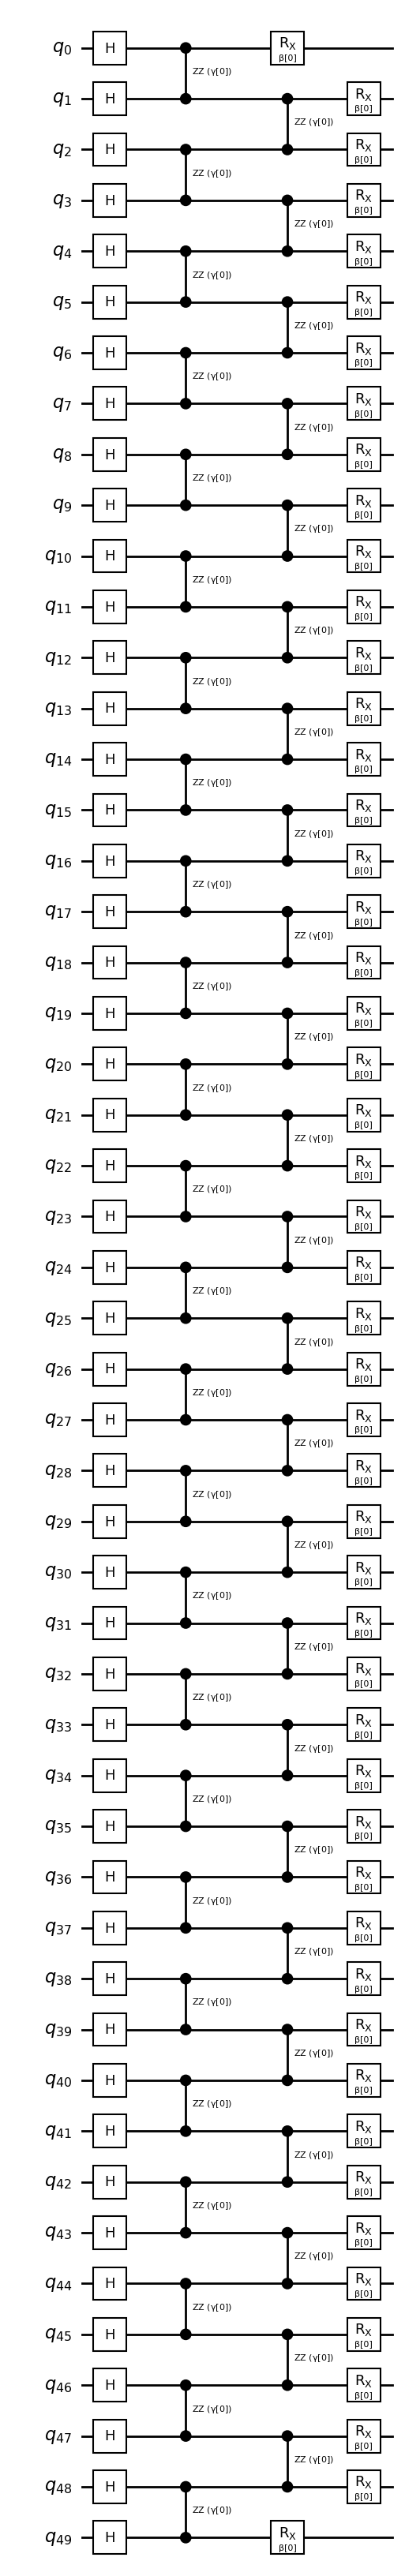

In [2]:
num_qubits = 50
p = 1
qaoa = build_qaoa_circuit(num_qubits,2*p)
qaoa.draw('mpl', style='bw', fold=-1)

Now we annotate the circuit for cutting by inserting proper **CutWire** to create two roughly equal cuts. We set *use_cut=True* in the function, and allow it to annotate after n/2 qubits, n being the number of qubits in the original circuit.

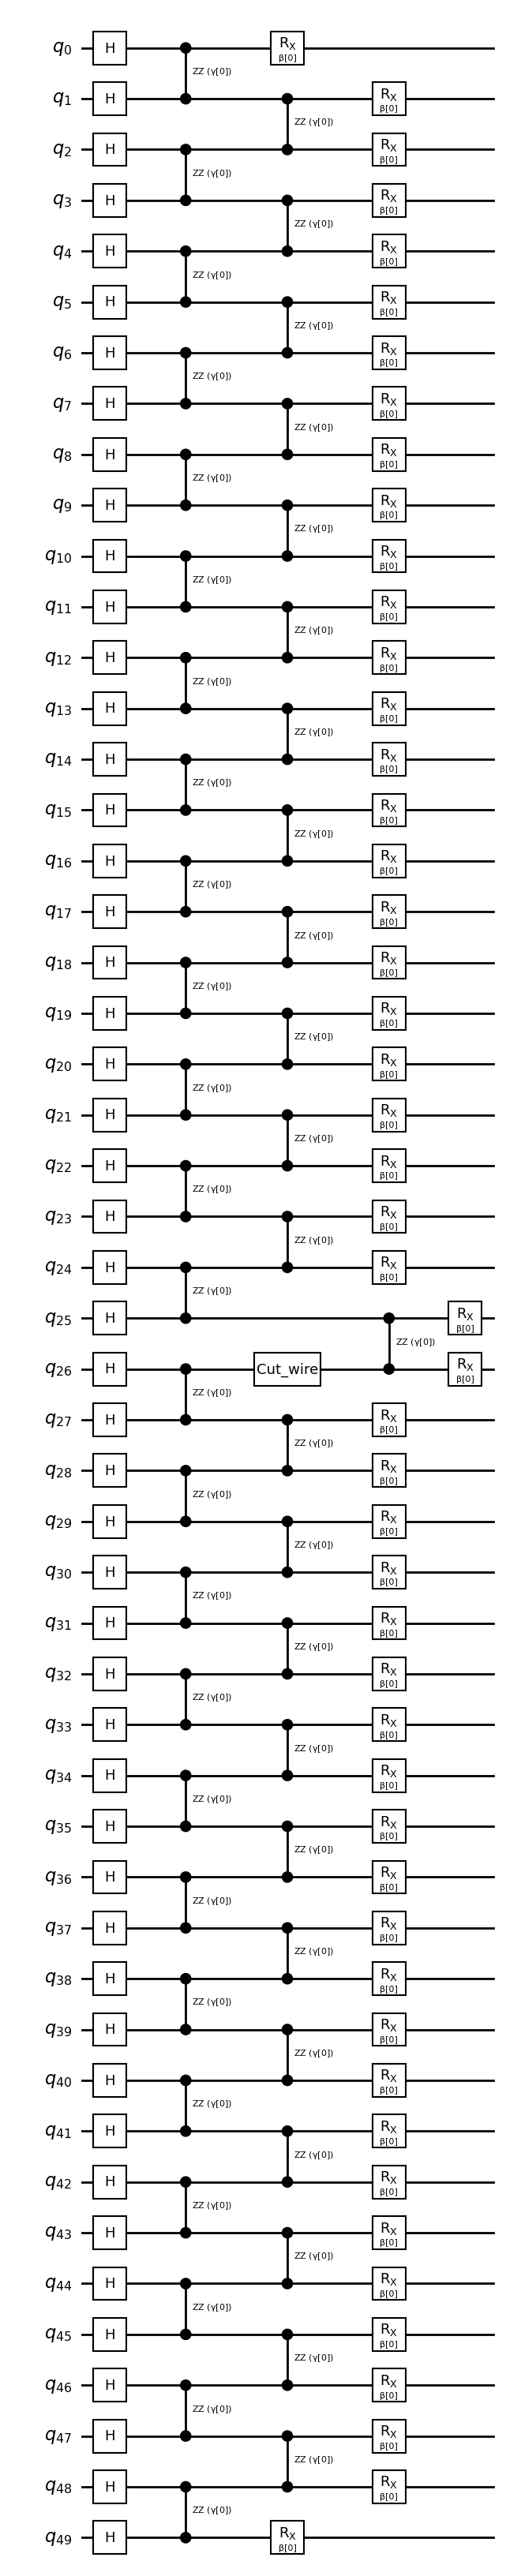

In [3]:
qaoa_cut = build_qaoa_circuit(num_qubits,2*p,use_cut=True)
qaoa_cut.draw('mpl', style='bw', fold=-1)

### Optimize

#### Cut the circuit into smaller subcircuits

Next we cut the circuit into two smaller subcircuits. For this example, we stick to only 2 subcircuits. For this, we use the <a href="https://qiskit-extensions.github.io/circuit-knitting-toolbox/index.html">Circuit Knitting Toolbox</a> from Qiskit Ecosystem.

Before running this notebook, it is necessary to install the Circuit Knitting Toolbox. This can be done simply by executing

<i>pip install circuit_knitting_toolbox</i>

Cutting the wire at a point increases the qubit count by one. Apart from the original qubit, there is now an extra qubit as a placeholder to the circuit after cutting. The following image gives a representation:

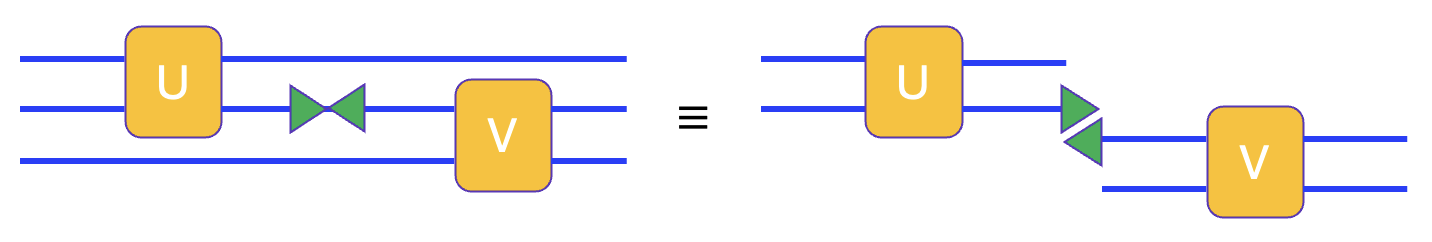

Note that it is possible to imagine this cut location as a virtual 2-qubit *cut gate*, thus making wire cutting equivalent to gate cutting.

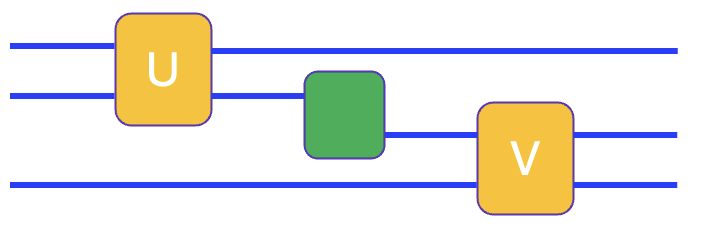

Circuit-knitting-toolbox replaces each **CutWire** annotation by a virtual 2-qubit **Move** operation.

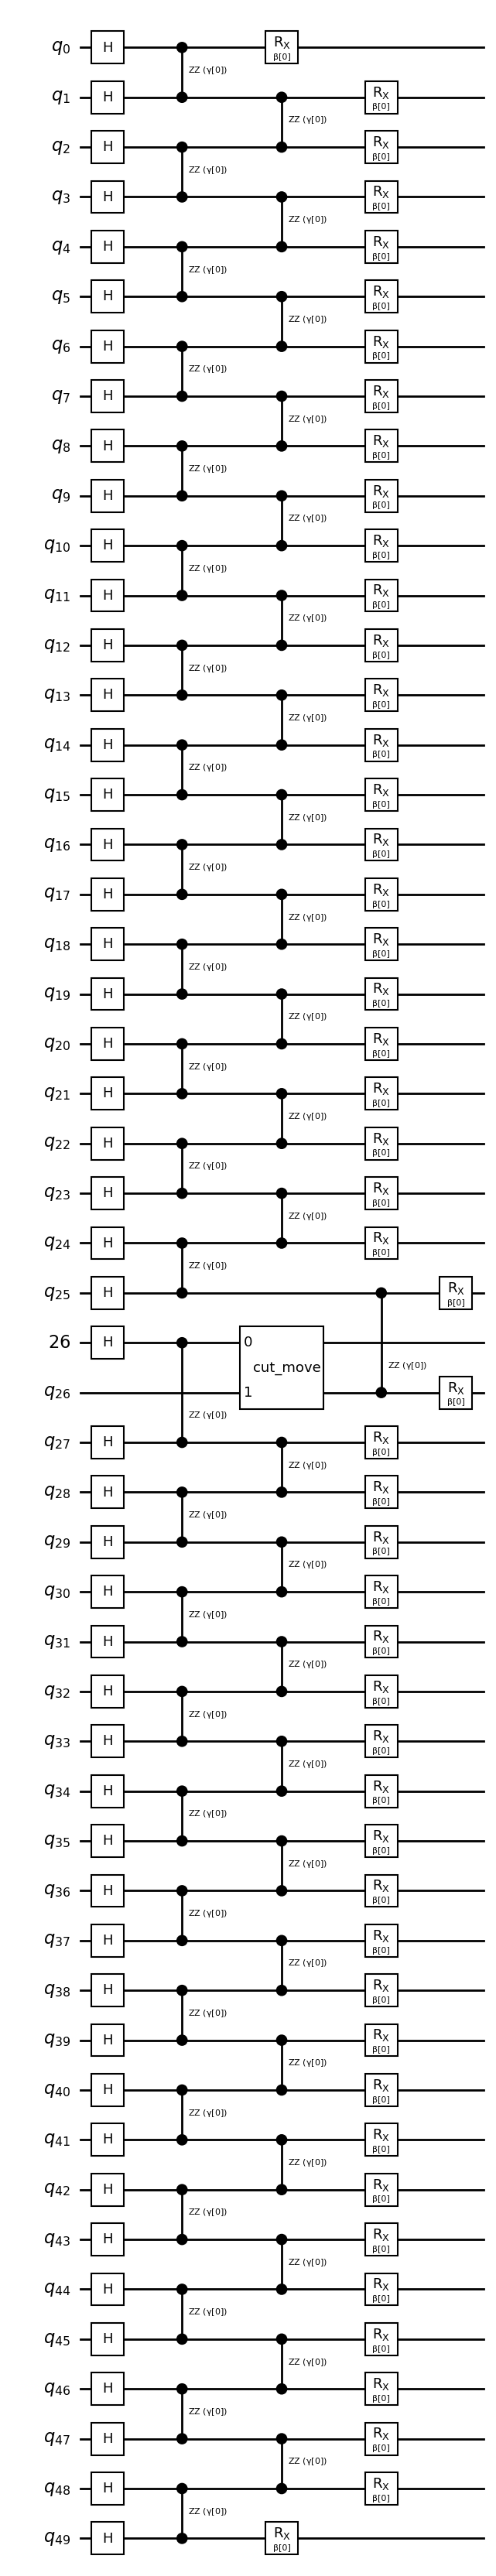

In [4]:
from circuit_knitting.cutting import cut_wires, expand_observables

qaoa_move = cut_wires(qaoa_cut)
qaoa_move.draw('mpl', style='bw', fold=-1)

#### Create and expand the observables

First we create the observable for the problem. Since we have considered a QAOA circuit, we shall use the observable corresponding to the Max-Cut problem: $\sum_{(i,j)\in E} Z_i Z_j$. Note that the lower the value of this observable, the better is the result. This allows us to compare the performance of this algorithm with and without circuit cutting, even without knowing the exact result.

Here, we first create the $Z_i Z_j$ observables for each edge.

In [5]:
from qiskit.quantum_info import PauliList

observable = PauliList(['I'*i + 'ZZ' + 'I'*(num_qubits-i-2) for i in range(num_qubits-1)])
observable

PauliList(['ZZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII',
           'IZZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII',
           'IIZZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII',
           'IIIZZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII',
           'IIIIZZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII',
           'IIIIIZZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII',
           'IIIIIIZZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII',
           'IIIIIIIZZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII',
           'IIIIIIIIZZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII',
           'IIIIIIIIIZZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII',
           'IIIIIIIIIIZZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII',
           'IIIIIIIIIIIZZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII',
           'IIIIIIIIIIIIZZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII',
           'IIIIIIIIIIIIIZZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII',
           'IIIIIIIIIIIIIIZZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII',
           'IIIIIIIIIIIII

However, note that the number of qubits in the circuit has increased after inserting the virtual 2-qubit **Move** operations after cutting. Therefore, we expand the observables as well by inserting identitites to assert to the current circuit.

In [6]:
new_obs = expand_observables(observable, qaoa, qaoa_move)
new_obs

PauliList(['ZZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...',
           'IZZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...',
           'IIZZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...',
           'IIIZZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...',
           'IIIIZZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...',
           'IIIIIZZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...',
           'IIIIIIZZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...',
           'IIIIIIIZZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...',
           'IIIIIIIIZZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...',
           'IIIIIIIIIZZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...',
           'IIIIIIIIIIZZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...',
           'IIIIIIIIIIIZZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...',
           'IIIIIIIIIIIIZZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...',
           'IIIIIIIIIIIIIZZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...',
           'IIIIIIIIIIIIIIZZIIIIIIIIIIIIIIIIIIII

Now we shall partition the circuit into two subcircuits

In [7]:
from circuit_knitting.cutting import (
    partition_problem,
    generate_cutting_experiments,
    reconstruct_expectation_values,
)

partitioned_problem = partition_problem(circuit=qaoa_move, observables=new_obs)

Let us visualize the subcircuits

In [8]:
subcircuits = partitioned_problem.subcircuits

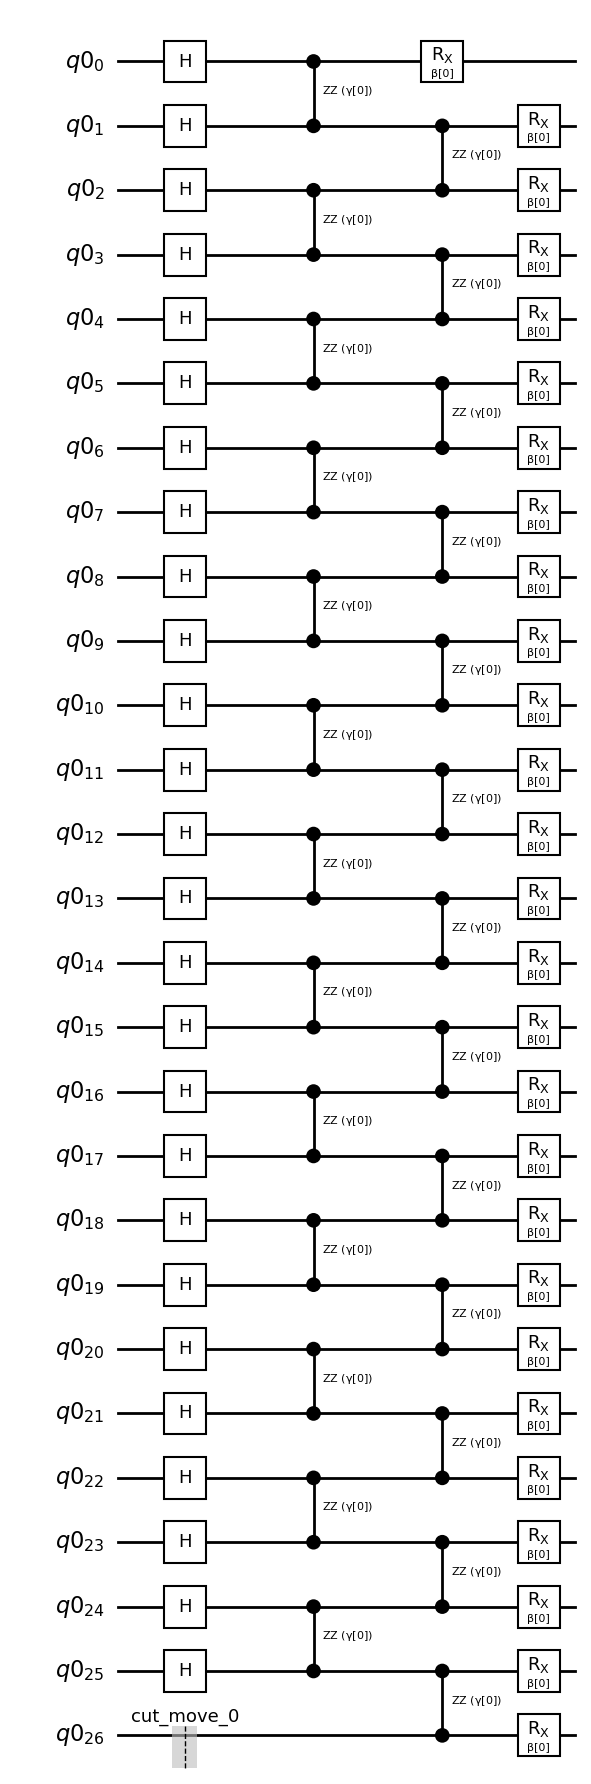

In [9]:
subcircuits[0].draw('mpl', style='bw', fold=-1)

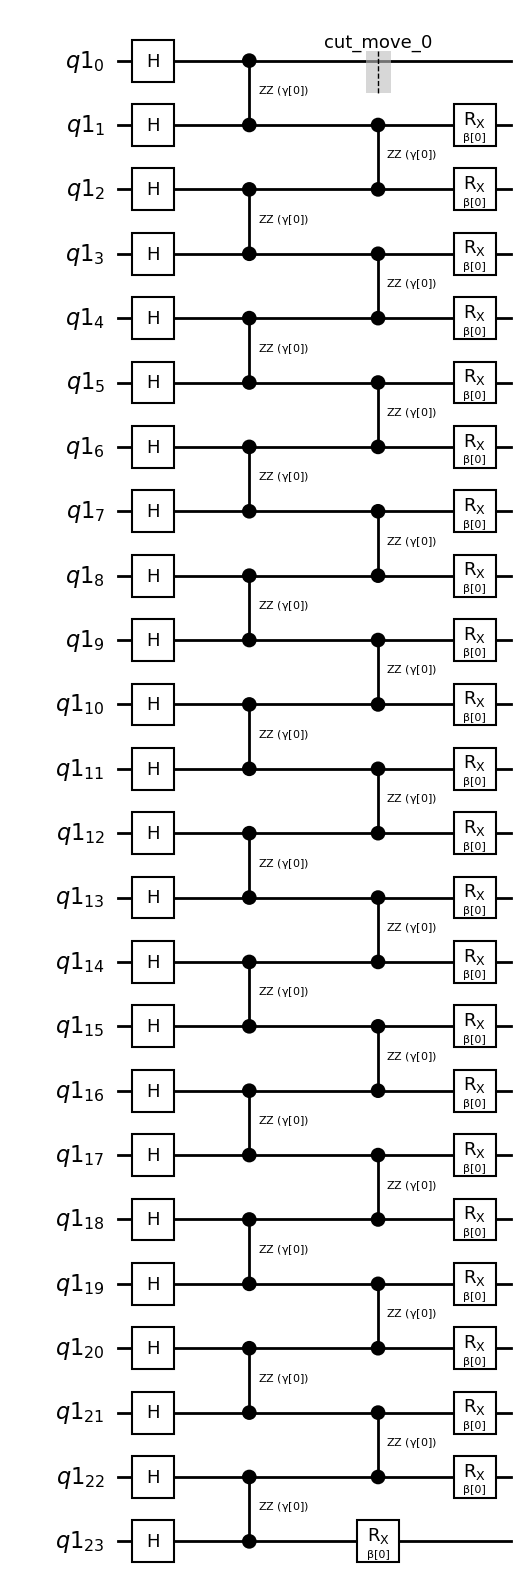

In [10]:
subcircuits[1].draw('mpl', style='bw', fold=-1)

The observables have been partitioned as well to fit the subcircuits

In [11]:
subobservables = partitioned_problem.subobservables
subobservables

{0: PauliList(['IIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIII',
            'IIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIII',
            'IIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIII',
            'IIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIII',
            'IIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIII',
            'IIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIII',
            'IIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIII',
            'IIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIII',
            'IIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIII',
            'IIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIII',
            'IIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIII',
            'ZIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZZIIIIIIIIIIIIIIIIIIIIIIIII',
            'IZZIIIIIIIIIIIIIIIIIIIIIIII', 'IIZZIIIIIIIIIIIIIIIIIIIIIII',
            'IIIZZIIIIIIIIIIIIIIIII

### Run and postprocess

Note that each subcircuit leads to a number of samples. The reconstruction takes into account the outcome of each of these samples. Each of these samples is termed a *subexperiment* in Circuit-knitting-toolbox.

In [12]:
import numpy as np

subexperiments, coefficients = generate_cutting_experiments(
    circuits=subcircuits,
    observables=subobservables,
    num_samples=np.inf,
)

#### Transpile each subexperiment

Currently we need to traspile our circuits before submitting them for execution. Therefore, we shall transpile each circuit in the subexperiments first.

In [13]:
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Options, Session

service = QiskitRuntimeService()

In [14]:
backend = service.backend('ibm_pinguino1')

In [15]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

pm = generate_preset_pass_manager(2, backend)

We transpile each circuit in the subexperiment

In [16]:
subexperiments_trans = {}

for key, subckt in subexperiments.items():
    subexperiments_trans[key] = pm.run(subckt)

#### Run the optimization

Recall that we aim to find the expectation value of the observable $\sum_{(i,j) \in edge}Z_i Z_j$. This expectation value is proportional to the Max-Cut value of the QAOA upto some constant terms [5]. The lower is the value, the better it is.

We initialize the initial set of parameters to some random value.

Note that due to the iterative method of QAOA, the run and postprocess steps are shown together. For each step, the circuit is executed, and the postprocessing step (i) calculates the expectation value for the observable, and in case of cutting (ii) merges the outcomes of different subcircuits.

In [17]:
init_params = produce_qaoa_parameters(p, seed=0)

Note that for each layer of QAOA there are two parameters. Therefore, each cut subcircuit also has two parameters. This makes the parameter assignment simpler. However, for more general problems, it is necessary to keep track of which parameter goes to which subcircuit, so that the assignment is proper.

In [18]:
options = Options()
options.execution.shots = 4000
options.transpilation.skip_transpilation = True
options.resilience_level = 0

In [19]:
def calculate_cut_expval(params: list, subexperiments: dict, coefficients: list, subobservables: dict, sampler) -> float:
    # assign parameters
    circuits = {}
    for key, ckt_list in subexperiments.items():
        circuits[key] = []
        for ckt in ckt_list:
            circuits[key].append(ckt.assign_parameters(params))

    # execute the circuits
    results = {
        label: sampler.run(subexp).result()
        for label, subexp in circuits.items()
    }

    # reconstruct and calculate expectation values
    reconstructed_expvals = reconstruct_expectation_values(
        results,
        coefficients,
        subobservables,
    )

    # return the sum of the expectation values
    return sum(reconstructed_expvals)

Often the optimization may run for hundreds of steps. For this example, we prematuredly stop the optimization.

In [20]:
from scipy.optimize import minimize

with Session(backend=backend):
    sampler = Sampler(options=options)
    res = minimize(
        calculate_cut_expval, init_params, args=(subexperiments_trans, coefficients, subobservables, sampler), method="cobyla", options={'maxiter':10}
    )

In [21]:
res

 message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: -18.93506837499775
       x: [-6.910e-01  8.084e-01]
    nfev: 10
   maxcv: 0.0

### Cross verify

Let us now run the same QAOA without circuit cutting, keeping other parameters and variables same.

In [22]:
from qiskit_ibm_runtime import Estimator
from qiskit.quantum_info import SparsePauliOp

#### Transpile and map the observables

In [23]:
trans_qaoa = pm.run(qaoa)

We need the layout of the transpiled circuit to map the observables

In [24]:
layout = trans_qaoa.layout.final_index_layout()
layout

[4,
 3,
 2,
 1,
 0,
 14,
 18,
 19,
 20,
 33,
 39,
 40,
 41,
 53,
 60,
 59,
 58,
 71,
 77,
 76,
 75,
 90,
 94,
 95,
 96,
 97,
 98,
 91,
 79,
 80,
 81,
 82,
 83,
 92,
 102,
 101,
 100,
 110,
 118,
 119,
 120,
 121,
 122,
 111,
 104,
 105,
 106,
 93,
 87,
 86]

In [25]:
observable = SparsePauliOp(observable)
observable

SparsePauliOp(['ZZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IZZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIZZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIZZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIZZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIZZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIZZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIZZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIZZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIZZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIZZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIZZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIZZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIZZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIZZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIZZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIZZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIZZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIII

Now we apply the final layout to the observable. Note that the mapped observable is not only expanded to include the ancilla qubits, they are also mapped to respect the layout of the transpiled circuit

In [26]:
observable = observable.apply_layout(layout, num_qubits=backend.num_qubits)
observable

SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIZZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIZZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIZIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIZIIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIZZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII

#### Execute

In [27]:
def calculate_uncut_expval(params: list, circ: QuantumCircuit, observsble: SparsePauliOp, estimator) -> float:
    # assign parameters
    circuit = circ.assign_parameters(params)
    
    # execute
    expval = estimator.run(circuit, observable).result().values[0]

    return expval

In [28]:
with Session(backend=backend):
    estimator = Estimator(options=options)
    res = minimize(
        calculate_uncut_expval, init_params, args=(trans_qaoa, observable, estimator), method="cobyla", options={'maxiter':10}
    )

In [29]:
res

 message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: -17.819000000000003
       x: [-7.419e-01  8.364e-01]
    nfev: 10
   maxcv: 0.0

### Inference

Recall that the observable was selected from the Max-Cut problem, and lower the value of the objective function, the better it is. We observe that after 10 steps of iteration, the uncut QAOA reached an objective function of -17.8 whereas the cut QAOA reached -18.9. This shows that cutting itself can suppress the effect of noise by lowering the number of qubits and/or gates.

Note that it is possible to use other error suppression and mitigation methods together with circuit cutting to further improve the performance. Moreover, in this notebook, we computed both the subcircuits on the same hardware. In [7], the authors shows a method to distribute the subcircuits on different hardware using noise information in order to maximize the noise suppression, and parallelize the process.

<b>Word of caution</b>

The number of circuits to be executed increases exponentially with the number of cuts. Therefore, while many cuts can produce small subcircuits, thus further improving the performance, it also leads to a significantly high number of circuit executions, which may not be practical for most cases. Therefore, circuit cutting should be used only when the number of cuts is small.

<b>References</b>

<ol>
  <li>Peng, T., Harrow, A. W., Ozols, M., & Wu, X. (2020). Simulating large quantum circuits on a small quantum computer. Physical review letters, 125(15), 150504.</li>
  <li>Tang, W., Tomesh, T., Suchara, M., Larson, J., & Martonosi, M. (2021, April). Cutqc: using small quantum computers for large quantum circuit evaluations. In Proceedings of the 26th ACM International conference on architectural support for programming languages and operating systems (pp. 473-486).</li>
  <li>Perlin, M. A., Saleem, Z. H., Suchara, M., & Osborn, J. C. (2021). Quantum circuit cutting with maximum-likelihood tomography. npj Quantum Information, 7(1), 64.</li>
  <li>Majumdar, R., & Wood, C. J. (2022). Error mitigated quantum circuit cutting. arXiv preprint arXiv:2211.13431.</li>
  <li>Farhi, E., Goldstone, J., & Gutmann, S. (2014). A quantum approximate optimization algorithm. arXiv preprint arXiv:1411.4028.</li>
  <li>Khare, T., Majumdar, R., Sangle, R., Ray, A., Seshadri, P. V., & Simmhan, Y. (2023). Parallelizing Quantum-Classical Workloads: Profiling the Impact of Splitting Techniques. In 2023 IEEE International Conference on Quantum Computing and Engineering (QCE) (Vol. 1, pp. 990-1000). IEEE.</li>
  <li>Bhoumik, D., Majumdar, R., Saha, A., & Sur-Kolay, S. (2023). Distributed Scheduling of Quantum Circuits with Noise and Time Optimization. arXiv preprint arXiv:2309.06005.</li>
</ol>

In [32]:
from qiskit import __version__

__version__

'1.0.1'